In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import scipy.stats as st
import scipy.io as sio
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import statsmodels.stats.multicomp as multi
import matplotlib.dates as md
import datetime
from math import sqrt
import plotly.graph_objects as go
%matplotlib inline
from scipy.stats import iqr
from statistics import median 
from math import sin, cos, sqrt, atan2, radians
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


/Users/Bujin/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [264]:
#Reading file with all the states name
states = pd.read_csv("/Users/Bujin/Downloads/States.csv")

#Reading dates
dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d') for d in dates]

#Defining output
DF=pd.DataFrame()
Slope=pd.DataFrame()
OT=pd.DataFrame()
adjusted=[]
idw=[]
total_mon=0

#Calling each state file
for i in range (0,len(states)):
    Data = pd.read_csv("/Users/Bujin/Downloads/"+str(states['state'][i])+" Pm 2.5.csv",parse_dates=['Date'], date_parser=dateparse)
    a=[x for x in  list(set(Data['ID'])) if pd.notnull(x)] #each unique monitors in each state
    total_mon=total_mon+len(a) #Counting total monitors

    #Defining output
    df=pd.DataFrame()
    slope1=pd.DataFrame()
    ot=pd.DataFrame()
    
    #for each station calculate D value   
    for iii in range(0,len(a)):
       monitor=Data[Data['ID']==a[iii]]
       
       #Defining as variables
       site=list(monitor['Site'])[1]        
       state=list(monitor['State'])[1] 
       idd=list(monitor['ID'])[1]
       county=list(monitor['County'])[1]
       lon=(list(monitor['Longitude'])[1])
       lat=(list(monitor['Latitude'])[1])
       weeknum=0
    
       #Defining output
       List10=[] 
       slope=[]  
    
       #Starting filters
       
       #Days pre and post covid
       twentytwenty=pd.concat([monitor['Date'],monitor['2020']],axis=1,sort=False)
       twentytwenty=twentytwenty.dropna()
       whole=twentytwenty[twentytwenty['Date']<pd.to_datetime('2020-06-03')] ##Change this date (add 7 days each week)
       pre=whole[whole['Date']<pd.to_datetime('2020-03-19')]
       post=whole[whole['Date']>=pd.to_datetime('2020-03-19')]

       #Number of days for adjusting
       adjusting=monitor[monitor['Date']<pd.to_datetime('2020-06-17')] ## Change this date (add 7 days each week)

       #dropping years if it has incomplete data
       drop=adjusting.drop(['2020'],axis=1)
       drop=drop.dropna(thresh=0.75*len(adjusting), axis=1)
       
       #checking if it has 2 years out of last 3 years
       Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
       Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
       
       
       
       start='2020-01-01'
       
       #Using monitors that have enough data
       if len(drop.columns)>=10 and len(post)>=57  and len(adjusting)>=126 and len(pre)>=59 and len(Iqr.columns)>=2:   ##Change this (add 5 days on post and adjusting each week)
                                        
        for j in range(0,len(whole),7): # Week by week
            
           #Start and end date for each week
           start_d = pd.to_datetime(start) + datetime.timedelta(j)
           end_d = start_d + datetime.timedelta(7)
         
           week=monitor[monitor['Date']>=start_d]
           week=week[week['Date']<end_d]
            
           #Week 
           twenty=pd.DataFrame(week["2020"])
           weeknum=weeknum+1 #Week #
           
           #Month (for adjusting)
           end_date = list(week['Date'])[0] + datetime.timedelta(days=21) # +2 weeks
           start_date = list(week['Date'])[0] - datetime.timedelta(days=14) # -2 weeks

        
           # First 2 weeks of the year, add december data from previous year
           if pd.to_datetime('2020-01-01')== list(week['Date'])[0] :
               half=monitor[monitor["Date"]>='2020-12-18']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-22']
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011","2009":'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           elif list(week['Date'])[0]==pd.to_datetime('2020-01-08'):
               half=monitor[monitor["Date"]>'2020-12-24']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-29'] 
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011",'2009':'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           else:
               month=monitor[monitor["Date"]>=start_date]
               month=month[month["Date"]<end_date]
               month=month.drop(['2009'],axis=1)
        
           #if len(month.columns)==19:
               #month=month.drop(['2009'],axis=1)
           
           Mnth=month.drop(['2020'], axis=1)
           
           #Change the 2020 data to only that particular week
           month["2020"]=twenty
           
           #Dropping columns to get only historical data
           months=month.drop(['2020'],axis=1)
           months=months.drop(['Site'],axis=1)
           months=months.drop(['State'],axis=1)
           months=months.drop(['Longitude'],axis=1)          
           months=months.drop(['Latitude'],axis=1)
           months=months.drop(['Date'],axis=1)
           months=months.drop(['ID'],axis=1)
           months=months.drop(['County'],axis=1)
           
           #Filtering data, using years that have enough data
           historical=months.dropna(thresh=0.75*len(months),axis=1)

        
           #Finding median for each year
           medians=np.nanmedian(historical,axis=0)
           
           #Finding iqr
           IQR_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=Iqr.columns)
           IQR_melt=IQR_melt.dropna()
           IQR_melt.columns = ['index', 'year', 'value']
           
           #Finding slope of historical data
           hist_slope=pd.DataFrame({"x":pd.to_numeric(historical.columns),"y":np.array(medians)})
           x=hist_slope["x"]
           y=hist_slope["y"]
        
           #Finding historical median
           
           Historical_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=historical.columns)
           Historical_melt.columns = ['index', 'year', 'value']
                               
            # Will get a slope if it has more than 8 years of data
           if len(historical.columns)>=8:
                  
                  #10 year median 
                  Med=np.nanmedian(Historical_melt['value'])  
                
                  #Finding historical slope and r2 value
                  trend, intercept, r_value, p_value, std_err = st.linregress(x,y)
                  
                  #Adjusting historical median
                  adjusted_med =  trend * (len(historical.columns)+1)/2 + Med

                  #Calculating D value 
                  D_value=(np.nanmedian(month['2020'])-adjusted_med)/iqr(IQR_melt['value'])  
                
                  #Appending for output
                  List10.append([D_value,np.nanmedian(month['2020']),Med,adjusted_med,trend,r_value**2,("Week "+str(weeknum)),site,state,idd,county,lat,lon])
                  
                  #Appending for idw
                  adjusted.append([idd,radians(lat),radians(lon),trend,"Week "+str(weeknum)])
                  slope.append(trend)
                  
                  
           else:

                  idw.append([idd,radians(lat),radians(lon)])
                  
                
        slope=pd.DataFrame(slope)
        
        #Preparing for idw
        
        if slope.size>0:
           slope.columns=[str(idd)]
         
        #Appending if it has 8 years of data
        if len(historical.columns)>=8:
          ot=pd.concat([ot,monitor],axis=0,sort=False)
        slope1=pd.concat([slope1,slope],axis=1,sort=False)   
        List10=pd.DataFrame(List10)
        df=pd.concat([df, List10], axis=0, sort=False)      

    #Concating for output
       
    OT=pd.concat([OT,ot],axis=0,sort=False)
    DF=pd.concat([DF, df], axis=0, sort=False)
    Slope=pd.concat([Slope,slope1],axis=1,sort=False)
    






/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [265]:
#Starting IDW
k1=pd.DataFrame(idw)
k1=k1.drop_duplicates()
k1.columns=['ID','Latitude','Longitude']
k1=k1.reset_index(drop=True)
IDW= list(k1['ID'])

k2=pd.DataFrame(adjusted)
k2.columns=['ID','Latitude','Longitude','Slope','Week']
k2=k2.drop(['Slope'],axis=1)
k2=k2.drop(['Week'],axis=1)
k2=k2.drop_duplicates()
adjusted=pd.DataFrame(adjusted)
adjusted.columns=['ID','Latitude','Longitude','Slope','Week']
k2.dropna()
k2=k2.drop_duplicates()

In [266]:
#IDW with nearest stations in 50km
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('haversine')
distance=pd.DataFrame(dist.pairwise(k2[['Latitude','Longitude']].to_numpy(), k1[['Latitude','Longitude']].to_numpy())*6373,columns=k1["ID"], index=k2["ID"])

In [267]:
#IDW
Slope1=pd.DataFrame()
w=[]

for i in range (0, len(IDW)):
    
    monitor=IDW[i]
    s=distance[monitor]
    
    #find 3 nearest monitors in 50 km
    nearest=s[s<50]
    nearest=nearest[nearest>0]
    nearest=nearest.sort_values(ascending=True)
    nearest=nearest[:3]
    idw=pd.DataFrame()
    
    #If there are monitors
    if len(nearest)!= 0:
        n=0
        
        o=list(nearest)
        
        #For each of the nearest monitors finding slope and distance:
        for j in range (0,len(nearest)):
            
            nearest_mon=nearest.index[j]
            nearest_slope=list(Slope[str(nearest_mon)])      
            nearest_slope.append(1/nearest.iloc[j])
            nearest_slope=pd.DataFrame(nearest_slope)
            nearest_slope.columns=[n]
            idw=pd.concat([idw,nearest_slope],axis=1,sort=False)
            n=n+1
            
            length=len(list(idw[0]))
            idw_df=pd.DataFrame()
            df=pd.DataFrame()
            
            #Dataframing slope for nearest monitor and inverse distance to that monitor
            for l in range (0,len(idw.columns)):
                 t=[]      
                 for m in range (0,length-1):

                         t.append([list(idw[l])[m]*list(idw[l])[length-1],list(idw[l])[length-1]])
                       #  print(list(idw[l])[m])
                 t=pd.DataFrame(t)

                 df=pd.concat([df,t],axis=1,sort=False) 
                 df=pd.DataFrame(df)
                 

        idw_df=pd.concat([idw_df,df],axis=1,sort=False)
        idw_df=idw_df.transpose()

        slp=[]
        
        #Aggregating nearest monitor slopes and distance 
        for z in range(0,len(idw_df.columns)):
                row=list(idw_df[z])
                nom=0
                denom=0
                for y in range (0,len(row)-1,2):
                    if pd.notnull(row[y]):
                     nom=nom+row[y]
                     
                     denom=denom+row[y+1]

                if denom!=0:
                 frac=nom/denom
                 slp.append(frac)
        slp=pd.DataFrame(slp)
        slp.columns=[monitor]

        #Output 
        Slope1=pd.concat([Slope1,slp],axis=1,sort=False)
            





In [268]:
#Finding D value from IDW

#Reading file with all the states name
states = pd.read_csv("/Users/Bujin/Downloads/States.csv")

#Reading dates
dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d') for d in dates]

#Defining output
DF1=pd.DataFrame()
Slope2=pd.DataFrame()
OT1=pd.DataFrame()
adjusted=[]
idw=[]


#Calling each state file
for i in range (0,len(states)):
    Data = pd.read_csv("/Users/Bujin/Downloads/"+str(states['state'][i])+" Pm 2.5.csv",parse_dates=['Date'], date_parser=dateparse)
    a=set(Data['ID']).intersection(Slope1.columns) #Taking the intersection of IDW monitors and all monitors
    a=list(a)

    #Defining output
    df=pd.DataFrame()
    slope1=pd.DataFrame()
    ot=pd.DataFrame()
    
    #for each station calculate D value   
    for iii in range(0,len(a)):
       monitor=Data[Data['ID']==a[iii]]
       
       #Defining as variables
       site=list(monitor['Site'])[1]        
       state=list(monitor['State'])[1] 
       idd=list(monitor['ID'])[1]
       county=list(monitor['County'])[1]
       lon=(list(monitor['Longitude'])[1])
       lat=(list(monitor['Latitude'])[1])
       weeknum=0
    
       #Defining output
       List10=[] 
       slope=[]  
    
       #Starting filters
       
       #Days pre and post covid
       twentytwenty=pd.concat([monitor['Date'],monitor['2020']],axis=1,sort=False)
       twentytwenty=twentytwenty.dropna()
       whole=twentytwenty[twentytwenty['Date']<pd.to_datetime('2020-06-03')] ##Change this date (add 7 days each week)
       pre=whole[whole['Date']<pd.to_datetime('2020-03-19')]
       post=whole[whole['Date']>=pd.to_datetime('2020-03-19')]

       #Number of days for adjusting
       adjusting=monitor[monitor['Date']<pd.to_datetime('2020-06-17')] ## Change this date (add 7 days each week)

       #dropping years if it has incomplete data
       drop=adjusting.drop(['2020'],axis=1)
       drop=drop.dropna(thresh=0.75*len(adjusting), axis=1)
       
       #checking if it has 2 years out of last 3 years
       Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
       Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
       
       
       
       start='2020-01-01'
       
       #Using monitors that have enough data
       if len(drop.columns)>=10 and len(post)>=57  and len(adjusting)>=126 and len(pre)>=59 and len(Iqr.columns)>=2:   ##Change this (add 5 days on post and adjusting each week)
                                        
        for j in range(0,len(whole),7): # Week by week
            
           #Start and end date for each week
           start_d = pd.to_datetime(start) + datetime.timedelta(j)
           end_d = start_d + datetime.timedelta(7)
         
           week=monitor[monitor['Date']>=start_d]
           week=week[week['Date']<end_d]
            
           #Week 
           twenty=pd.DataFrame(week["2020"])
           weeknum=weeknum+1 #Week #
           
           #Month (for adjusting)
           end_date = list(week['Date'])[0] + datetime.timedelta(days=21) # +2 weeks
           start_date = list(week['Date'])[0] - datetime.timedelta(days=14) # -2 weeks

        
           # First 2 weeks of the year, add december data from previous year
           if pd.to_datetime('2020-01-01')== list(week['Date'])[0] :
               half=monitor[monitor["Date"]>='2020-12-18']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-22']
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011","2009":'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           elif list(week['Date'])[0]==pd.to_datetime('2020-01-08'):
               half=monitor[monitor["Date"]>'2020-12-24']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-29'] 
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011",'2009':'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           else:
               month=monitor[monitor["Date"]>=start_date]
               month=month[month["Date"]<end_date]
               month=month.drop(['2009'],axis=1)
        
           #if len(month.columns)==19:
               #month=month.drop(['2009'],axis=1)
           
           Mnth=month.drop(['2020'], axis=1)
           
           #Change the 2020 data to only that particular week
           month["2020"]=twenty
           
           #Dropping columns to get only historical data
           months=month.drop(['2020'],axis=1)
           months=months.drop(['Site'],axis=1)
           months=months.drop(['State'],axis=1)
           months=months.drop(['Longitude'],axis=1)          
           months=months.drop(['Latitude'],axis=1)
           months=months.drop(['Date'],axis=1)
           months=months.drop(['ID'],axis=1)
           months=months.drop(['County'],axis=1)
           
           #Filtering data, using years that have enough data
           historical=months.dropna(thresh=0.75*len(months),axis=1)

           #Finding median for each year
           medians=np.nanmedian(historical,axis=0)
           
           #Finding iqr
           IQR_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=['2019', '2018', '2017'])
           IQR_melt=IQR_melt.dropna()
           IQR_melt.columns = ['index', 'year', 'value']
           
           #Finding slope of historical data
           hist_slope=pd.DataFrame({"x":pd.to_numeric(historical.columns),"y":np.array(medians)})
           x=hist_slope["x"]
           y=hist_slope["y"]
        
           #Finding historical median
           
           Historical_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=historical.columns)
           Historical_melt.columns = ['index', 'year', 'value']

                  
                  #10 year median 
           Med=np.nanmedian(Historical_melt['value'])  
                  
                  #Adjusting historical median with IDW slope
           adjusted_med =  list(Slope1[idd])[weeknum-1] * (len(historical.columns)+1)/2 + Med

                  #Calculating D value 
           D_value=(np.nanmedian(month['2020'])-adjusted_med)/iqr(IQR_melt['value'])  
                
                  #Appending for output
           List10.append([D_value,np.nanmedian(month['2020']),Med,adjusted_med,list(Slope1[idd])[weeknum-1],999,("Week "+str(weeknum)),site,state,idd,county,lat,lon])
           slope.append(list(Slope1[idd])[weeknum-1])       

                
        slope=pd.DataFrame(slope)
        
        #Preparing for idw
        
        if slope.size>0:
           slope.columns=[str(idd)]
         

        ot=pd.concat([ot,monitor],axis=0,sort=False)
        slope1=pd.concat([slope1,slope],axis=1,sort=False)   
        List10=pd.DataFrame(List10)
        df=pd.concat([df, List10], axis=0, sort=False)      

    #Concating for output
       
    OT1=pd.concat([OT1,ot],axis=0,sort=False)
    DF1=pd.concat([DF1, df], axis=0, sort=False)
    Slope2=pd.concat([Slope2,slope1],axis=1,sort=False)
    







/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [269]:
#Concat both outputs
MapData=pd.concat([DF,DF1],axis=0,sort=False)
MapData.columns=['Ratio','Median','Unadjusted','Expected','Slope','Rsquared','Week','Site','state','ID','County','Latitude','Longitude']

In [270]:
Map=MapData.dropna()
ag = Map.groupby('ID')['Week'].nunique()
Dta=pd.DataFrame()

for i in range (0,len(ag.index)):
    a=ag.index[i]
    indexNames = MapData[ MapData['ID'] == a ].index
    #using station that have at least 75% of the weeks
    if ag.iloc[i]>17:
      Dta=pd.concat([Dta,MapData[MapData['ID']==a]])
Dta=Dta.dropna()
Dta.drop_duplicates(subset=['Week', 'ID'], inplace=True, keep='first')
Dta.to_csv(r"/Users/Bujin/Downloads/PM 2.5 Map data non aggregated.csv", index = False)


In [272]:
Dta['ID'].nunique()

520

In [279]:
ET=pd.concat([OT,OT1],axis=0,sort=False)
ET

,Date,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,Site,State,ID,County,Latitude,Longitude
3294,2020-01-01,5.6,6.400000,7.7,4.833333,8.333333,13.50,12.700000,6.00,10.10,3.50,5.750000,6.40,Wylam,Alabama,10732003,Jefferson,33.499722,-86.924167
3295,2020-01-02,7.9,6.500000,7.4,2.800000,7.500000,7.90,7.433333,12.00,2.40,4.80,6.033333,10.90,Wylam,Alabama,10732003,Jefferson,33.499722,-86.924167
3296,2020-01-03,4.0,4.233333,6.0,9.700000,5.600000,6.00,6.200000,11.80,5.10,12.70,7.450000,9.75,Wylam,Alabama,10732003,Jefferson,33.499722,-86.924167
3297,2020-01-04,5.6,3.300000,7.2,6.200000,6.650000,3.20,7.000000,8.50,14.85,17.00,8.550000,6.90,Wylam,Alabama,10732003,Jefferson,33.499722,-86.924167
3298,2020-01-05,4.9,5.200000,8.5,9.900000,5.000000,7.70,8.650000,9.70,12.45,16.50,6.400000,5.95,Wylam,Alabama,10732003,Jefferson,33.499722,-86.924167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,2020-12-27,NaN,13.100000,11.3,9.200000,4.600000,2.70,7.850000,25.15,3.40,5.60,NaN,12.70,APPLETON - AAL,Wisconsin,550870009,Outagamie,44.307380,-88.395178
2192,2020-12-28,NaN,16.600000,2.7,13.500000,7.600000,2.40,10.700000,17.90,5.25,6.60,25.500000,4.40,APPLETON - AAL,Wisconsin,550870009,Outagamie,44.307380,-88.395178
2193,2020-12-29,NaN,7.600000,2.5,15.900000,4.850000,3.95,4.500000,6.40,4.70,19.55,NaN,8.50,APPLETON - AAL,Wisconsin,550870009,Outagamie,44.307380,-88.395178
2194,2020-12-30,NaN,4.400000,7.1,7.600000,3.100000,9.10,6.300000,9.75,19.90,15.10,NaN,20.60,APPLETON - AAL,Wisconsin,550870009,Outagamie,44.307380,-88.395178


In [280]:
n=list(ET["Date"])

for i in range (0,22):
    
    start_date = n[0] + datetime.timedelta(days=(i*7))
    end_date =start_date  + datetime.timedelta(days=7) 
    th=ET[ET['Date']<end_date]
    th=th[th['Date']>=start_date]
    globals()["week" + str(i+1)] = th

In [281]:
ww=ET[ET['Date']<='2020-01-31']
tw=np.nanmedian(ww['2020'])
on=np.nanmedian(ww['2019'])
oe=np.nanmedian(ww['2018'])
os=np.nanmedian(ww['2017'])
osi=np.nanmedian(ww['2016'])
of=np.nanmedian(ww['2015'])
ofo=np.nanmedian(ww['2014'])
oth=np.nanmedian(ww['2013'])
ot=np.nanmedian(ww['2012'])
oo=np.nanmedian(ww['2011'])
oz=np.nanmedian(ww['2010'])
qs=[]
qss=[]
qsss=[]
qssss=[]
qq=[]
qqq=[]
qqqq=[]
qqqqq=[]
qz=[]
qzz=[]
qzzz=[]
for j in range (0,22):
    tg=globals()["week" + str(j+1)]
    #print(tg)
    qs.append(np.nanmedian(tg['2020'])/tw)
    qss.append(np.nanmedian(tg['2019'])/on)
    qsss.append(np.nanmedian(tg['2018'])/oe)
    qssss.append(np.nanmedian(tg['2017'])/os)
    qq.append(np.nanmedian(tg['2016'])/osi)
    qqq.append(np.nanmedian(tg['2015'])/of)
    qqqq.append(np.nanmedian(tg['2014'])/ofo)
    qqqqq.append(np.nanmedian(tg['2013'])/oth)
    qz.append(np.nanmedian(tg['2012'])/ot)
    qzz.append(np.nanmedian(tg['2011'])/oo)
    qzzz.append(np.nanmedian(tg['2010'])/oz)
    
    



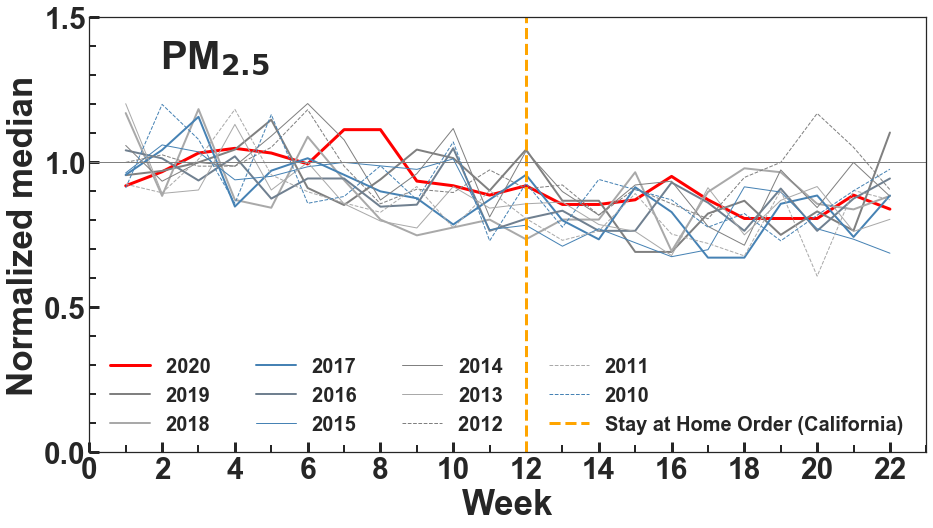

In [282]:
x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
fig= plt.figure(figsize=(15, 8))
plt.style.use('seaborn-white')
ax=fig.add_subplot(111)
plt.plot(x ,qs,color='red', label='2020 ',linewidth=3)
plt.plot(x,qss , color='grey',label='2019', linewidth=2)
plt.plot(x,qsss , color='darkgrey', label='2018',linewidth=2)
plt.plot(x,qssss , color='steelblue', label='2017',linewidth=2)
plt.plot(x ,qq,color='slategrey', label='2016 ',linewidth=2)
plt.plot(x,qqq , color='steelblue',label='2015', linewidth=1)
plt.plot(x,qqqq , color='grey', label='2014',linewidth=1)
plt.plot(x,qqqqq , color='darkgrey', label='2013',linewidth=1)
plt.plot(x ,qz,color='grey', label='2012 ',linewidth=1,linestyle='dashed')
plt.plot(x,qzz , color='darkgrey',label='2011', linewidth=1,linestyle='dashed')
plt.plot(x,qzzz , color='steelblue', label='2010',linewidth=1,linestyle='dashed')

plt.rcParams["axes.labelweight"] = "bold"
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_locator(MultipleLocator(2))
plt.ylim(0,1.5)
plt.xlim(0,23)
plt.axvline(x=12, color='orange', label='Stay at Home Order (California) ',linestyle='dashed',linewidth=3)
    #plt.axvspan('Week12', 'Week16', alpha=0.1, color='orange',label="Lockdown")
    #plt.xticks(1)
plt.axhline(y=1, color='grey',linewidth=1)
#plt.xticks(np.arange(0, max(x)+1, 2.0))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
plt.xlabel('Week',fontsize='35',fontweight='bold')
plt.ylabel('Normalized median',fontsize='35',fontweight='bold')
#plt.xlim(1,17)
ax.tick_params(axis='y', which='minor', bottom=True,direction='in',length=7, width=2)
ax.tick_params(axis='y', which='major', bottom=True,direction='in',length=10, width=3)
ax.tick_params(axis='x', which='major', bottom=True,direction='in',length=10, width=3)
ax.tick_params(axis='x', which='minor', bottom=True,direction='in',length=7, width=2)
#plt.ylabel('Median PM2.5 during weeks / Median PM 2.5 in January',fontsize='14', fontweight='bold')
plt.legend(loc='lower right',fontsize='20',frameon=False,ncol=4)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
                     label.set_fontname('Arial')
                     label.set_fontsize(30)
                     label.set_fontweight('bold')
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.rcParams["font.size"] = "20"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = "20"
plt.title('PM$_{2.5}$',fontsize='40',fontweight='bold',x=0.15,y=0.87)
plt.savefig('Pm 2.5 normalized to Jan.png', bbox_inches='tight')